In [13]:
import pickle # for saving objects

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px # for nice plotting

import re # for cleaning textual data (uses regular expressions ouch!)
from collections import Counter # for counting tokens occurences


import warnings

import math

import nltk
from nltk import download
from nltk.tokenize import RegexpTokenizer # for LSA in sklearn, we will need additional tokenizer
from nltk.tokenize import word_tokenize # for tokenization
from nltk.stem import PorterStemmer # for stemming
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer # one can consider LSA with DF in DTM...
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM

from sklearn.decomposition import LatentDirichletAllocation # LDA implementation


import stop_words # source: https://pypi.org/project/stop-words/#installation
from stop_words import get_stop_words # alternative stopwords list

import gensim
from gensim import corpora # for: Dictionary(), word2bow()
from gensim import models # for: TfidfModel()

import statistics # for: quantiles()

import numpy as np # for some maths

import time # for measuring time of computation

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [34]:
with open("cnn_data_df.pkl", "rb") as fp:
    cnn_data_df = pickle.load(fp)

In [35]:
#Initial data cleaning

#removing \n
cnn_texts = cnn_data_df[1].map(lambda x: re.sub('\n', ' ', x))

#removing all numbers
cnn_texts = cnn_texts.map(lambda x: re.sub(r'[0-9]+', '', x))

#removing ,\!?/:;''()``’“-”—#
cnn_texts = cnn_texts.map(lambda x: re.sub("[,\!?/:;''()``’“-”—#]", '', x))

#removing .
cnn_texts = cnn_texts.map(lambda x: re.sub(r"([.]+)", '', x))

#all letters to lover case
cnn_texts = cnn_texts.map(lambda x: x.lower())

#removing one-letter words
cnn_texts = cnn_texts.map(lambda x: re.sub(r'\b\w\b', '', x))

cnn_texts

0      brazilian footballer dani alves has been detai...
1      lionel messi and cristiano ronaldo put on  sho...
2      as she finished  zoom meeting with  colleague ...
3      the red-headed man wearing what looks like the...
4      the us state department rolled out  tool for a...
                             ...                        
365    with months to go until the  world cup in qata...
366    anatoliy trubin should be enjoying life as  pr...
367    netherlands coach louis van gaal said on sunda...
368    after more than  years of sour relations and m...
369    spain and germany will face off in the headlin...
Name: 1, Length: 370, dtype: object

In [36]:
# download("all")

In [37]:
#Tokenization

for i in range(0,len(cnn_texts)):
    cnn_texts[i] = word_tokenize(cnn_texts[i])

cnn_texts

0      [brazilian, footballer, dani, alves, has, been...
1      [lionel, messi, and, cristiano, ronaldo, put, ...
2      [as, she, finished, zoom, meeting, with, colle...
3      [the, red-headed, man, wearing, what, looks, l...
4      [the, us, state, department, rolled, out, tool...
                             ...                        
365    [with, months, to, go, until, the, world, cup,...
366    [anatoliy, trubin, should, be, enjoying, life,...
367    [netherlands, coach, louis, van, gaal, said, o...
368    [after, more, than, years, of, sour, relations...
369    [spain, and, germany, will, face, off, in, the...
Name: 1, Length: 370, dtype: object

In [38]:
#Stemming
ps = PorterStemmer()

for i in range(0,len(cnn_texts)):

    words = []
    for word in cnn_texts[i]:
        words.append(ps.stem(word)) #stems every token in document and append it to a list
                                    #it takes few minutes

cnn_texts

0      [brazilian, footballer, dani, alves, has, been...
1      [lionel, messi, and, cristiano, ronaldo, put, ...
2      [as, she, finished, zoom, meeting, with, colle...
3      [the, red-headed, man, wearing, what, looks, l...
4      [the, us, state, department, rolled, out, tool...
                             ...                        
365    [with, months, to, go, until, the, world, cup,...
366    [anatoliy, trubin, should, be, enjoying, life,...
367    [netherlands, coach, louis, van, gaal, said, o...
368    [after, more, than, years, of, sour, relations...
369    [spain, and, germany, will, face, off, in, the...
Name: 1, Length: 370, dtype: object

In [39]:
#Stopwords
stop_words = nltk.corpus.stopwords.words('english') #one of stopwords dictionaries available in Python

# cleaning stopwords
stop_words = pd.Series(stop_words).map(lambda x: re.sub('\n', '', x))
stop_words = stop_words.map(lambda x: re.sub("[,\!?/:;''()``]", '', x))
stop_words = stop_words.map(lambda x: re.sub(r"([.]+)", '', x))

# stemming stopwords
ps = PorterStemmer()
for i in range(0,len(stop_words)):
    stop_words[i] = ps.stem(stop_words[i])

#making stopwords back a list
stop_words = list(stop_words)

#adding some specific stopwords
stop_words.append('``')
stop_words.append("\'\'")
stop_words.extend(['world','his','cup','was','were','its','this','has','have'])

# removing stopwords from cnn texts
for i in range(0,len(cnn_texts)):
    cnn_texts[i] = [word for word in cnn_texts[i] if not word in list(stop_words)]
cnn_texts

0      [brazilian, footballer, dani, alves, detained,...
1      [lionel, messi, cristiano, ronaldo, put, show,...
2      [finished, zoom, meeting, colleague, dr, célin...
3      [red-headed, man, wearing, looks, like, ultima...
4      [us, state, department, rolled, tool, afghans,...
                             ...                        
365    [months, go, qatar, less, week, since, draw, t...
366    [anatoliy, trubin, enjoying, life, professiona...
367    [netherlands, coach, louis, van, gaal, said, s...
368    [years, sour, relations, months, struggle, res...
369    [spain, germany, face, headline, act, group, s...
Name: 1, Length: 370, dtype: object

In [40]:
cnn_data_df[3] = cnn_texts
cnn_data_df
save_object(cnn_data_df, r'cnn_data_df_preprocessed.pkl')
save_object(cnn_data_df, r'cnn_data_df_preprocessed.txt')

### Ngrams

In [16]:
def generate_ngrams(text, ngram = 1):
    temp = zip(*[text[i:] for i in range(0,ngram)]) # set with pairs, three, ..., ns of tokens
    ans = [' '.join(ngram) for ngram in temp] # joins the elements in strings
    ans = pd.Series(ans).map(lambda x: re.sub(" ", '_', x)) # replaces spaces with '_'
    return list(ans)

In [17]:
for i in range(0,len(cnn_texts)):
    unigrams = cnn_texts[i]
    bigrams = generate_ngrams(cnn_texts[i], ngram = 2)
    trigrams = generate_ngrams(cnn_texts[i], ngram = 3)

    text = []
    text.append(unigrams)
    text.append(bigrams)
    text.append(trigrams)

    cnn_texts[i] = [item for sublist in text for item in sublist]
    # so called 'list comprehension'
    # More: https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists

cnn_texts

0      [brazilian, footballer, dani, alves, detained,...
1      [lionel, messi, cristiano, ronaldo, put, show,...
2      [finished, zoom, meeting, colleague, dr, célin...
3      [red-headed, man, wearing, looks, like, ultima...
4      [us, state, department, rolled, tool, afghans,...
                             ...                        
365    [months, go, qatar, less, week, since, draw, t...
366    [anatoliy, trubin, enjoying, life, professiona...
367    [netherlands, coach, louis, van, gaal, said, s...
368    [years, sour, relations, months, struggle, res...
369    [spain, germany, face, headline, act, group, s...
Name: 1, Length: 370, dtype: object

### Term frequency (TF)

In [23]:
#dictionary from gensim library = keys are: 1, 2, 3, ..., number of tokens; values are tokens' names
dictionary = corpora.Dictionary(cnn_texts)

#corpus from gensim library consists of so called bows
#every bow = keys are tokens' indexes; values are numbers of tokens' occurences in text
corpus = [dictionary.doc2bow(text) for text in cnn_texts]

In [24]:
def TF(dictionary, corpus, which_text):

    #corpus from gensim library consists of so called bows
    #every bow = keys are tokens' indexes; values are numbers of tokens' occurences in text
    bow = dict(corpus[which_text])


    #dict_combined = keys are tokens' names; values are numbers of tokens' occurences in text
    bow_dict_combined = dict((dictionary[key], value) for (key, value) in bow.items())

    TFdictionary = {}
    bow_count = sum(bow_dict_combined.values()) #number of tokens in text

    for word, count in bow_dict_combined.items():
        TFdictionary[word] = count/bow_count

    return TFdictionary

In [27]:
TF(dictionary, corpus, 362) #Term Frequency in document no. 363


{'also': 0.0021645021645021645,
 'calls': 0.0021645021645021645,
 'champions': 0.006493506493506494,
 'champions_league': 0.006493506493506494,
 'city': 0.0021645021645021645,
 'cup': 0.004329004329004329,
 'football': 0.0021645021645021645,
 'has': 0.0021645021645021645,
 'league': 0.012987012987012988,
 'national': 0.0021645021645021645,
 'players': 0.004329004329004329,
 'qatar': 0.0021645021645021645,
 'said': 0.004329004329004329,
 'this': 0.006493506493506494,
 'was': 0.0021645021645021645,
 'world': 0.006493506493506494,
 'world_cup': 0.004329004329004329,
 'years': 0.0021645021645021645,
 'bid': 0.0021645021645021645,
 'international': 0.0021645021645021645,
 'organizers': 0.0021645021645021645,
 'portugal': 0.0021645021645021645,
 'sporting': 0.0021645021645021645,
 'two': 0.0021645021645021645,
 'announced': 0.0021645021645021645,
 'began': 0.0021645021645021645,
 'body': 0.004329004329004329,
 'coming': 0.0021645021645021645,
 'its': 0.0021645021645021645,
 'numerous': 0.002

In [28]:
d = {} # this dictionary will include all tokens names as keys and all TF values found for those tokens in a form of list

for i in range(0,len(corpus)): # for each text
    data = TF(dictionary, corpus, i) # calculates TF for all tokens in text

    for token, tf in data.items(): # for each token and calculated TF
        d.setdefault(token, []).append(tf) # fills dictionary named 'd'

In [29]:
d

{'according': [0.0021645021645021645,
  0.0005640157924421884,
  0.001287001287001287,
  0.0006242197253433209,
  0.0005973715651135006,
  0.001004016064257028,
  0.0015290519877675841,
  0.0007168458781362007,
  0.000859106529209622,
  0.0006121824303642485,
  0.0006680026720106881,
  0.0005640157924421884,
  0.0006775067750677507,
  0.0011695906432748538,
  0.0011111111111111111,
  0.0028089887640449437,
  0.00029761904761904765,
  0.0014005602240896359,
  0.00044033465433729633,
  0.0016339869281045752,
  0.000992063492063492,
  0.0008375209380234506,
  0.0010515247108307045,
  0.0004110152075626798,
  0.002697841726618705,
  0.00026624068157614486,
  0.0007168458781362007,
  0.00039494470774091627,
  0.0010070493454179255,
  0.00030637254901960784,
  0.00019036740909956216,
  0.00030892801977139327,
  0.0005136106831022085,
  0.0018726591760299626,
  0.0009442870632672333,
  0.0006802721088435374,
  0.0006422607578676942,
  0.0007869058860560277,
  0.0015723270440251573,
  0.000508

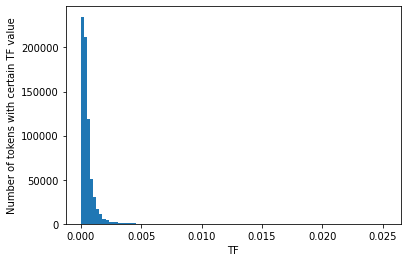

In [30]:
# dictionary 'd' looks like above, let us take TF values only - we will have list of lists
# the below makes list of lists a list
tf_values = [item for sublist in list(d.values()) for item in sublist]

#now, simple histogram
plt.hist(tf_values, bins=100)
plt.xlabel('TF')
plt.ylabel('Number of tokens with certain TF value')
plt.show()

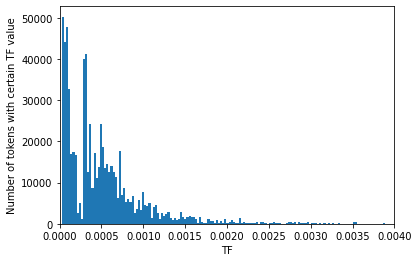

In [31]:
plt.hist(tf_values, bins=1000)
plt.xlabel('TF')
plt.ylabel('Number of tokens with certain TF value')
plt.xlim([0, 0.004]) # limit on x axis
plt.show()

### Inverse Document Frequency (IDF)

In [32]:
def IDF(corpus, dictionary):
    occurence = {}

    for i in range(0,len(corpus)):

        #corpus from gensim library consists of so called bows
        #every bow = keys are tokens' indexes; values are numbers of tokens' occurences in text
        bow = dict(corpus[i])

        #dict_combined = keys are tokens' names; values are numbers of tokens' occurences in text
        bow_dict_combined = dict((dictionary[key], value) for (key, value) in bow.items())

        # creates a dictionary where keys are tokens' names and values are lists of tokens' non-zero counts in texts
        for token, count in bow_dict_combined.items():
            occurence.setdefault(token, []).append(count)

    IDFdictionary = {}

    # based on tokens' counts dictionary woth tokens' names and IDF values is computed
    for token, counts in occurence.items():
        IDFdictionary[token] = np.log(len(corpus)/len(counts))

    return(IDFdictionary)

In [33]:
IDFdictionary = IDF(corpus, dictionary)

In [34]:
IDFdictionary

{'according': 0.7544477064237411,
 'according_police': 5.220355825078324,
 'according_police_spokesperson': 5.91350300563827,
 'allegations': 2.655406467616788,
 'allegations_catalonia': 5.91350300563827,
 'allegations_catalonia_higher': 5.91350300563827,
 'allegations_want': 5.91350300563827,
 'allegations_want_deny': 5.91350300563827,
 'alleged': 2.41699544417179,
 'alleged_sexual': 4.814890716970161,
 'alleged_sexual_assault': 4.814890716970161,
 'also': 0.33755390249195405,
 'also_said': 2.617666139633941,
 'also_said_alves': 5.91350300563827,
 'also_three': 5.220355825078324,
 'also_three_champions': 5.220355825078324,
 'alves': 4.30406509320417,
 'alves_copa': 5.220355825078324,
 'alves_copa_américa': 5.91350300563827,
 'alves_has': 5.91350300563827,
 'alves_has_detained': 5.91350300563827,
 'alves_has_domestic': 5.91350300563827,
 'alves_investigation': 5.220355825078324,
 'alves_investigation_alleged': 5.220355825078324,
 'alves_one': 5.220355825078324,
 'alves_one_decorated': 

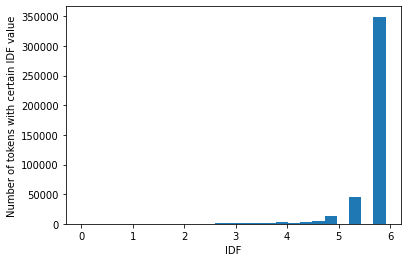

In [35]:
idf_values = list(IDFdictionary.values()) # takes values from IDF dictionary and makes it a list

# histogram of IDF values
# please note that it is an inversen measure!
# to remove least 'popular' terms we should remove the ones with highest IDF values
plt.hist(idf_values, bins=25)
plt.xlabel('IDF')
plt.ylabel('Number of tokens with certain IDF value')
plt.show()

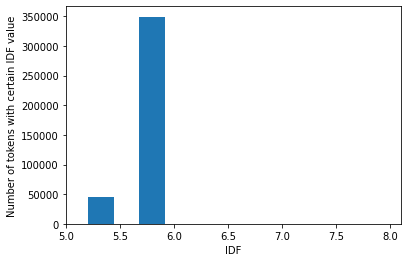

In [36]:
# let us zoom the plot above
plt.hist(idf_values, bins=25)
plt.xlabel('IDF')
plt.ylabel('Number of tokens with certain IDF value')
plt.xlim([5, 8.1])
plt.show()

### TF-IDF

In [37]:
tfidf_model = models.TfidfModel(corpus, id2word = dictionary)


In [38]:
def TFIDF(dictionary, corpus, which_text, tfidf_model):
    bow = corpus[which_text]
    tfidfdictionary = dict(tfidf_model[bow]) #TFIDF for tokens in a chosen text

    #below: keys are tokens' names; values are numbers of tokens' occurences in text
    TFIDFdictionary = dict((dictionary[key], value) for (key, value) in tfidfdictionary.items())

    return(TFIDFdictionary)

In [39]:
TFIDF(dictionary, corpus, 362, tfidf_model)


{'also': 0.003058060749815512,
 'calls': 0.022175482038927403,
 'champions': 0.046040118337889055,
 'champions_league': 0.057871376376128505,
 'city': 0.010826108695897046,
 'football': 0.004307088544151015,
 'has': 0.0009002623271033629,
 'league': 0.07111684173575275,
 'national': 0.005849202598623639,
 'players': 0.00992061289831236,
 'qatar': 2.4518212101140394e-05,
 'said': 0.0028584595376945137,
 'this': 0.0022183171247456496,
 'was': 0.0007129105487113069,
 'world_cup': 4.903642420228079e-05,
 'years': 0.003808979335631951,
 'bid': 0.020618609131597722,
 'international': 0.007594821371266919,
 'organizers': 0.019290458792042834,
 'portugal': 0.014828880957609224,
 'sporting': 0.016330871553526246,
 'two': 0.0036978187527602316,
 'announced': 0.012908542016012,
 'began': 0.013540854895533916,
 'body': 0.02149115901857916,
 'coming': 0.01301091004125872,
 'its': 0.001119233079675187,
 'numerous': 0.02790580361419792,
 'right': 0.011155580416950134,
 'seasons': 0.0296647549482494,


In [40]:
#For all
d_tfidf = {}

for i in range(0,len(corpus)): # for each text
    data = TFIDF(dictionary, corpus, i, tfidf_model) # calculate TFIDF values for text's tokens

    for token, value in data.items(): # next, for each token and its TFIDF value in text, prepare a dictionary
                                      # with tokens' names as keys and list of TF-IDFs as values
        d_tfidf.setdefault(token, []).append(value)

In [41]:
d_tfidf

{'according': [0.006863794138635667,
  0.0033589113129962977,
  0.004814198941355778,
  0.004771114270408732,
  0.004922593839472357,
  0.004740023005911228,
  0.004176598827374168,
  0.003832730660633557,
  0.005566398479428704,
  0.003450008241841103,
  0.005431172799710916,
  0.003222840604051663,
  0.0051873183766556995,
  0.005062342735636327,
  0.004940948615271236,
  0.014339895848099811,
  0.0025226978754803804,
  0.00852952076725738,
  0.0032498760694260687,
  0.006047526177806332,
  0.004933953867117716,
  0.0058840271947022465,
  0.006769987757444234,
  0.0031419079379333887,
  0.02241756412458464,
  0.0038384156842328284,
  0.004262227987097199,
  0.002862329043673996,
  0.005250562713283064,
  0.0028163246810812563,
  0.002165536653415223,
  0.0025073388186517775,
  0.0034486557496789493,
  0.021348068115865097,
  0.005394337370525251,
  0.004502966644954507,
  0.004041364495355916,
  0.009515837915567113,
  0.008701476883652868,
  0.0034534825789550934,
  0.00348272032858

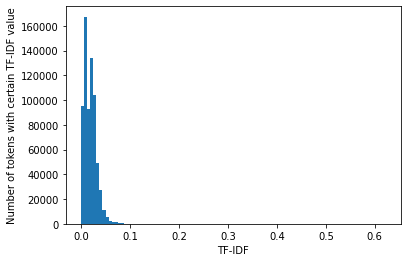

In [42]:
tfidf_values = [item for sublist in list(d_tfidf.values()) for item in sublist]

plt.hist(tfidf_values, bins=100)
plt.xlabel('TF-IDF')
plt.ylabel('Number of tokens with certain TF-IDF value')
plt.show()

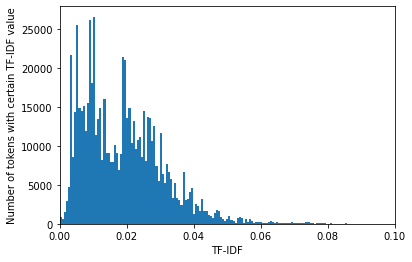

In [43]:
plt.hist(tfidf_values, bins=1000)
plt.xlabel('TF-IDF')
plt.ylabel('Number of tokens with certain TF-IDF value')
plt.xlim([0, 0.1])
plt.show()

### Filtering with respect to TF-IDF

In [67]:
def TFIDF_FILTER(texts, lower_bound=0.0001, higher_bound=99999):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    tfidf_model = models.TfidfModel(corpus, id2word=dictionary)

    new_texts = texts.copy()
    for i in range(0, len(corpus)):  #each text sequentially
        scores = TFIDF(dictionary, corpus, 0, tfidf_model)  #TFIDF for tokens in the text

        tokens_to_stay = []

        for token, tfidf in scores.items():
            if ((tfidf > lower_bound) and (tfidf < higher_bound)):
                tokens_to_stay.append(token)

        for j in range(0, len(texts)):
            new_texts[j] = [t for t in texts[j] if t in tokens_to_stay]

    return (new_texts)


In [69]:
print('Text no. 1 had',len(cnn_texts[0]),'tokens. After filtering with IDF, there are',len(TFIDF_FILTER(cnn_texts[0:10], lower_bound = 0.02)[0]),'tokens.')

Text no. 1 had 462 tokens. After filtering with IDF, there are 426 tokens.


In [70]:
# text no. 1 before filtering with TF-IDF (sample of first 10 texts), first 10 tokens displayed
cnn_texts[0][0:10]

['brazilian',
 'footballer',
 'dani',
 'alves',
 'has',
 'detained',
 'police',
 'barcelona',
 'relation',
 'investigation']

In [71]:
# text no. 1 after filtering with TF, first 10 tokens displayed
TFIDF_FILTER(cnn_texts[0:10], lower_bound = 0.02)[0][0:10]

['brazilian',
 'footballer',
 'dani',
 'alves',
 'detained',
 'police',
 'barcelona',
 'relation',
 'investigation',
 'alleged']